# 1. Recommendation System with LSH

In this section, you will implement a recommendation system by identifying users with similar preferences and suggesting movies based on their behavior. Specifically, you will implement your version of the [LSH algorithm](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/)

## 1.1 Data Preparation

### 1.1.1 Download the dataset

Download the MovieLens dataset from [here](https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset?select=rating.csv).

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download grouplens/movielens-20m-dataset

Dataset URL: https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset
License(s): unknown
movielens-20m-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

# Unzip the file
zipfile_path = 'movielens-20m-dataset.zip'
with zipfile.ZipFile(zipfile_path, 'r') as zip:
    zip.extractall('.')  # Extract files to the current directory

### 1.1.2 EDA

After downloading, explore the dataset to understand the structure and identify any preprocessing steps needed.

**About Dataset**

The datasets describe ratings and free-text tagging activities from MovieLens, a movie recommendation service. It contains 20.000.263 ratings and 465.564 tag applications across 27.278 movies. These data were created by 138.493 users between January 09, 1995 and March 31, 2015. This dataset was generated on October 17, 2016.

Users were selected at random for inclusion. All selected users had rated at least 20 movies.

**Content**

No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in six files:

Each file is then imported in a Pandas DataFrame.



In [ ]:
import pandas as pd

# One Pandas DataFrame for each .csv
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')
links = pd.read_csv('link.csv')
movies = pd.read_csv('movie.csv')
ratings = pd.read_csv('rating.csv')
tags = pd.read_csv('tag.csv')

These six dataframes (*movie*, *rating*, *tag*, *link*, *genome_scores* and *genome_tags*) represent different information related to movies, users, and their interactions.

We can proceed with an initial exploration of the six dataframes.

#### Dataframe: **movies**

The *movies* dataframe provides essential information about the movies in our dataset. Here's a breakdown:

* **movieId**: A unique numerical ID for each movie. This is the primary key for identifying movies across different tables.
* **title**: The title of the movie. Originally, it included the release year in parentheses, but we've cleaned it up during preprocessing to contain only the title.
* **genres**: A list of genres associated with the movie. Initially, this was a pipe-separated string, but we've converted it into a list of individual genre strings for easier analysis.

We've also added a **year** column during preprocessing by extracting the year from the original **title**.

In [ ]:
# Movies dataframe
print("Movies dataframe:\n")
print(movies.head().to_markdown())
print(movies.info())

Movies dataframe:

|    |   movieId | title                              | genres                                      |
|---:|----------:|:-----------------------------------|:--------------------------------------------|
|  0 |         1 | Toy Story (1995)                   | Adventure|Animation|Children|Comedy|Fantasy |
|  1 |         2 | Jumanji (1995)                     | Adventure|Children|Fantasy                  |
|  2 |         3 | Grumpier Old Men (1995)            | Comedy|Romance                              |
|  3 |         4 | Waiting to Exhale (1995)           | Comedy|Drama|Romance                        |
|  4 |         5 | Father of the Bride Part II (1995) | Comedy                                      |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres

In [ ]:
# Extract year from title and update title column
import re

def extract_year(title):
  """
  Extracts the year from a movie title string and removes it from the title.

  Args:
    title: The movie title string.

  Returns:
    A tuple containing the cleaned title and the year as an integer,
    or None if no year is found.
  """
  match = re.search(r'(.*)\((\d{4})\)', title)
  if match:
    return match.group(1).strip(), int(match.group(2))
  else:
    return title, None

# Apply the function and create 'year' and updated 'title' columns
movies[['title', 'year']] = movies['title'].apply(extract_year).apply(pd.Series)

# Transform 'genres' into an array of strings
movies['genres'] = movies['genres'].str.split('|')

# Print the first few rows to verify the changes
print(movies.head().to_markdown())

|    |   movieId | title                       | genres                                                      |   year |
|---:|----------:|:----------------------------|:------------------------------------------------------------|-------:|
|  0 |         1 | Toy Story                   | ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'] |   1995 |
|  1 |         2 | Jumanji                     | ['Adventure', 'Children', 'Fantasy']                        |   1995 |
|  2 |         3 | Grumpier Old Men            | ['Comedy', 'Romance']                                       |   1995 |
|  3 |         4 | Waiting to Exhale           | ['Comedy', 'Drama', 'Romance']                              |   1995 |
|  4 |         5 | Father of the Bride Part II | ['Comedy']                                                  |   1995 |


#### Dataframe: **ratings**

The **ratings** dataframe is all about capturing how users interact with movies. It's essentially a big table where each row records a specific user giving a specific movie a particular rating.

Here's the gist of its columns:

* **userId**: A unique ID for each user in the system.
* **movieId**: This links the rating to the movie it's about, matching the IDs in the **movies** dataframe.
* **rating**: The actual rating the user gave the movie, likely on a scale (like 0.5 to 5 stars).
* **timestamp**: This tells us when the user gave the rating.

In [ ]:
print("\nRatings dataframe:")
print(ratings.head().to_markdown())
print(ratings.info())
print(ratings['rating'].describe().to_markdown())


Ratings dataframe:
|    |   userId |   movieId |   rating | timestamp           |
|---:|---------:|----------:|---------:|:--------------------|
|  0 |        1 |         2 |      3.5 | 2005-04-02 23:53:47 |
|  1 |        1 |        29 |      3.5 | 2005-04-02 23:31:16 |
|  2 |        1 |        32 |      3.5 | 2005-04-02 23:33:39 |
|  3 |        1 |        47 |      3.5 | 2005-04-02 23:32:07 |
|  4 |        1 |        50 |      3.5 | 2005-04-02 23:29:40 |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB
None
|       |      rating |
|:------|------------:|
| count | 2.00003e+07 |
| mean  | 3.52553     |
| std   | 1.05199     |
| min   | 0.5         |
| 25%   | 3           |
| 50%   | 3.5         |
| 75%   | 4         

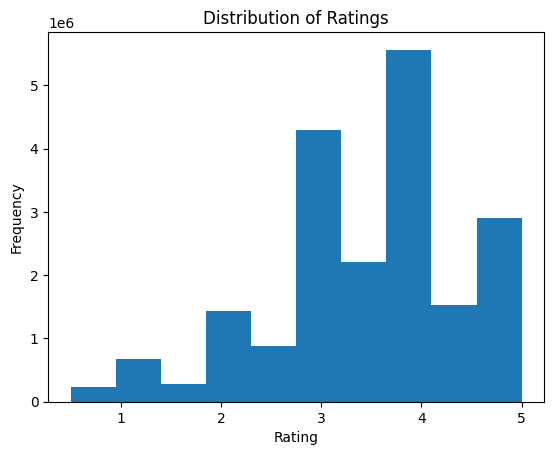

In [ ]:
# Histogram of rating distribution
import matplotlib.pyplot as plt
plt.hist(ratings['rating'], bins=10)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

#### Dataframe: **tags**

The **tags** dataframe gives us insights into how users perceive and describe movies. It's a record of tags or keywords that users have associated with specific films.

Here's a rundown of its key components:

* **userId**: A unique identifier for each user who has provided a tag.
* **movieId**: This connects the tag to the movie it refers to, aligning with the **movieId** in the **movies** dataframe.
* **tag**: The actual tag or keyword that the user has assigned to the movie. These are usually short phrases or terms that describe some aspect of the film, like "atmospheric," "mind-bending," or "slow burn."
* **timestamp**: This indicates when the user added the tag.

In [ ]:
print("\nTags dataframe:")
print(tags.head().to_markdown())
print(tags.info())


Tags dataframe:
|    |   userId |   movieId | tag           | timestamp           |
|---:|---------:|----------:|:--------------|:--------------------|
|  0 |       18 |      4141 | Mark Waters   | 2009-04-24 18:19:40 |
|  1 |       65 |       208 | dark hero     | 2013-05-10 01:41:18 |
|  2 |       65 |       353 | dark hero     | 2013-05-10 01:41:19 |
|  3 |       65 |       521 | noir thriller | 2013-05-10 01:39:43 |
|  4 |       65 |       592 | dark hero     | 2013-05-10 01:41:18 |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465564 entries, 0 to 465563
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     465564 non-null  int64 
 1   movieId    465564 non-null  int64 
 2   tag        465548 non-null  object
 3   timestamp  465564 non-null  object
dtypes: int64(2), object(2)
memory usage: 14.2+ MB
None


#### Dataframe: **links**

The **links** dataframe acts like a bridge between our movie dataset and the wider world of movie information. It provides connections to external resources where we can potentially find more details about each film.

Here's what it contains:

* **movieId**: Our familiar unique identifier for each movie, ensuring consistency with the other dataframes.
* **imdbId**: This is the corresponding movie ID on IMDb (Internet Movie Database), a massive online database of movie information, cast and crew details, user reviews, and more.
* **tmdbId**: This links to The Movie Database (TMDb), another popular online resource for movie data, including posters, trailers, and fan discussions.

In [ ]:
print("\nLinks dataframe:")
print(links.head().to_markdown())
print(links.info())


Links dataframe:
|    |   movieId |   imdbId |   tmdbId |
|---:|----------:|---------:|---------:|
|  0 |         1 |   114709 |      862 |
|  1 |         2 |   113497 |     8844 |
|  2 |         3 |   113228 |    15602 |
|  3 |         4 |   114885 |    31357 |
|  4 |         5 |   113041 |    11862 |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  27278 non-null  int64  
 1   imdbId   27278 non-null  int64  
 2   tmdbId   27026 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 639.5 KB
None


#### Dataframe: **Genome scores**

The **genome_scores** dataframe provides a way to connect movies with a predefined set of tags, giving us a more standardized way to describe the films.

Here's what it contains:

* **movieId**: This links the scores to the specific movie, matching the movieId in the movies dataframe.
* **tagId**: This refers to a specific tag from a predefined set of tags called the "genome." Each **tagId** represents a particular characteristic or theme.
* **relevance**: This score indicates how strongly the tag is associated with the movie. It's a numerical value that represents the relevance of the tag to the movie, on a scale from 0 to 1, where higher scores indicate a stronger association.

In essence, this dataframe gives us a structured way to understand the thematic content of movies. Instead of relying solely on user-generated tags, which can be inconsistent and subjective, the genome scores provide a more standardized and objective way to describe the movies.

In [ ]:
print("\nGenome scores dataframe:")
print(genome_scores.head().to_markdown())
print(genome_scores.info())
print(genome_scores['relevance'].describe().to_markdown())


Genome scores dataframe:
|    |   movieId |   tagId |   relevance |
|---:|----------:|--------:|------------:|
|  0 |         1 |       1 |     0.025   |
|  1 |         1 |       2 |     0.025   |
|  2 |         1 |       3 |     0.05775 |
|  3 |         1 |       4 |     0.09675 |
|  4 |         1 |       5 |     0.14675 |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 268.0 MB
None
|       |   relevance |
|:------|------------:|
| count | 1.17098e+07 |
| mean  | 0.116483    |
| std   | 0.154246    |
| min   | 0.00025     |
| 25%   | 0.02425     |
| 50%   | 0.0565      |
| 75%   | 0.1415      |
| max   | 1           |


#### Dataframe: **Genome tags**

The **genome_tags** dataframe is like a dictionary that explains the meaning of the tags used in the **genome_scores** dataframe.  It provides the textual descriptions for the numerical **tagId** values.

Here's what it tells us:

* **tagId**: A unique numerical identifier for each tag in the genome. This corresponds to the **tagId** used in the **genome_scores** dataframe.
* **tag**: The actual textual description of the tag, providing a human-understandable label for the **tagId**. For example, a **tagId** of 2 correspond to the tag "007 (series)".

Essentially, this dataframe acts as a lookup table to decode the **tagId** values in the **genome_scores** dataframe.

In [ ]:
print("\nGenome tags dataframe:")
print(genome_tags.head().to_markdown())
print(genome_tags.info())


Genome tags dataframe:
|    |   tagId | tag          |
|---:|--------:|:-------------|
|  0 |       1 | 007          |
|  1 |       2 | 007 (series) |
|  2 |       3 | 18th century |
|  3 |       4 | 1920s        |
|  4 |       5 | 1930s        |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB
None


#### EDA (further exploration)

1. **Rating Distribution by User**

The histogram shows that most users have rated a relatively small number of movies.
There are a few users who have rated a very large number of movies (power users).

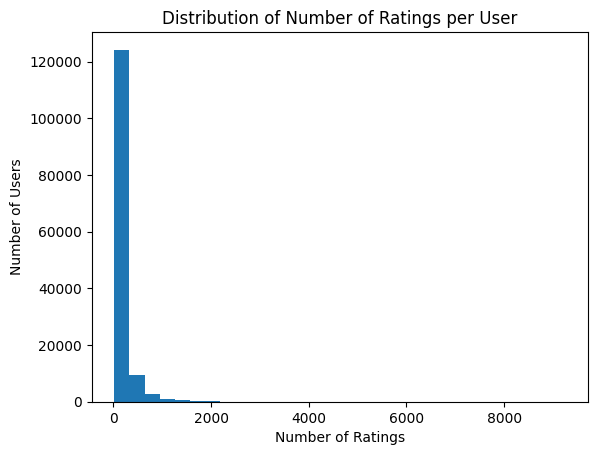

In [ ]:
# 1. Rating Distribution by User
user_ratings_count = ratings.groupby('userId')['rating'].count()
plt.hist(user_ratings_count, bins=30)
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

2. **Rating Distribution by Movie**

Similarly, most movies have received only a small number of ratings.
A few movies have a very high number of ratings, likely indicating popular or well-known films.

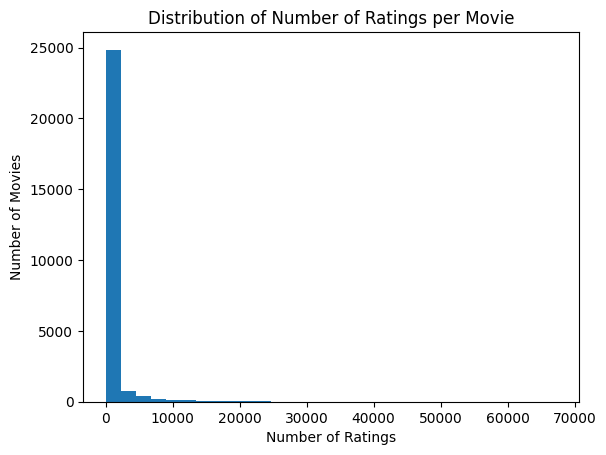

In [ ]:
# 2. Rating Distribution by Movie
movie_ratings_count = ratings.groupby('movieId')['rating'].count()
plt.hist(movie_ratings_count, bins=30)
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()

3. **Average Rating per Movie**

The distribution of average ratings seems to be roughly centered around 3.5, with a slight skew towards higher ratings. This suggests that users tend to rate movies more favorably on average.

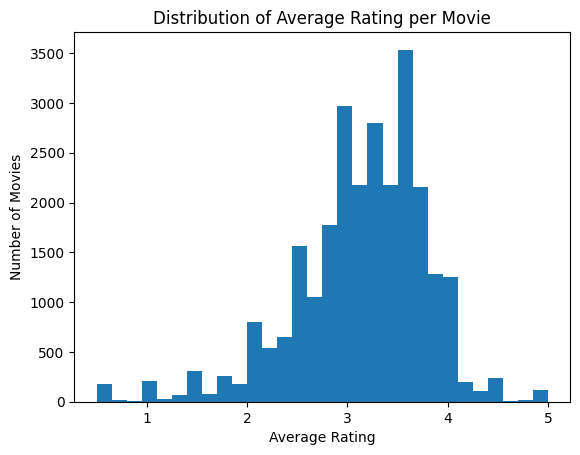

In [ ]:
# 3. Average Rating per Movie
average_movie_rating = ratings.groupby('movieId')['rating'].mean()
plt.hist(average_movie_rating, bins=30)
plt.title('Distribution of Average Rating per Movie')
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.show()

4. **Top Rated Movies**

This list gives us an idea of which movies are highly rated by users.

* **Classics Dominate**: As expected, many of the top-rated movies are critically acclaimed classics like "The Shawshank Redemption," "The Godfather," and "Schindler's List." These films have consistently received high praise and are popular among cinephiles.
* **High Number of Ratings**: The **num_ratings** column confirms that these top-rated movies have been rated by a significant number of users. This adds weight to their average rating, as it suggests a broader consensus among viewers.

In [ ]:
# 4. Top Rated Movies (with minimum number of ratings)

min_ratings_threshold = 50  # Consider movies with at least this many ratings

# Calculate average rating and number of ratings per movie
average_movie_rating = ratings.groupby('movieId')['rating'].mean()
movie_ratings_count = ratings.groupby('movieId')['rating'].count()

# Filter for movies with enough ratings and sort by average rating
top_rated_movies = average_movie_rating[movie_ratings_count >= min_ratings_threshold].sort_values(ascending=False)

# Merge with movies dataframe to get titles
top_rated_movies = top_rated_movies.reset_index().merge(movies[['movieId', 'title']], on='movieId')

# Add number of ratings to the output
top_rated_movies['num_ratings'] = top_rated_movies['movieId'].map(movie_ratings_count)

# Display the top-rated movies with title and number of ratings
print("\nTop Rated Movies:\n", top_rated_movies[['movieId', 'title', 'rating', 'num_ratings']].head(10).to_markdown())


Top Rated Movies:
 |    |   movieId | title                                  |   rating |   num_ratings |
|---:|----------:|:---------------------------------------|---------:|--------------:|
|  0 |       318 | Shawshank Redemption, The              |  4.44699 |         63366 |
|  1 |       858 | Godfather, The                         |  4.36473 |         41355 |
|  2 |        50 | Usual Suspects, The                    |  4.33437 |         47006 |
|  3 |       527 | Schindler's List                       |  4.31018 |         50054 |
|  4 |      1221 | Godfather: Part II, The                |  4.27564 |         27398 |
|  5 |      2019 | Seven Samurai (Shichinin no samurai)   |  4.27418 |         11611 |
|  6 |       904 | Rear Window                            |  4.27133 |         17449 |
|  7 |      7502 | Band of Brothers                       |  4.26318 |          4305 |
|  8 |       912 | Casablanca                             |  4.25833 |         24349 |
|  9 |       922 | Suns

5. **Tag Analysis - Most Popular Tags**

This analysis reveals the most frequently used tags, giving us insights into the common themes and characteristics that users associate with movies. We can see that some of the most popular tags include "sci-fi", "based on a book", "atmospheric", "action", "comedy" and "surreal"

In [ ]:
# 5. Tag Analysis - Most Popular Tags
tag_counts = tags['tag'].value_counts()
print("\nMost Popular Tags:\n", tag_counts.head(10).to_markdown())


Most Popular Tags:
 | tag             |   count |
|:----------------|--------:|
| sci-fi          |    3384 |
| based on a book |    3281 |
| atmospheric     |    2917 |
| comedy          |    2779 |
| action          |    2657 |
| surreal         |    2427 |
| BD-R            |    2334 |
| twist ending    |    2323 |
| funny           |    2072 |
| dystopia        |    1991 |


6. **Genre-Rating Relationship**

This analysis shows that some genres, such as "Film-Noir" and "War," tend to have higher average ratings, while others, like "Horror" and "Sci-Fi," have slightly lower average ratings. This could be due to differences in user preferences or the types of movies that fall into each genre.

In [ ]:
# 6. Genre-Rating Relationship
genre_rating = movies.explode('genres').merge(ratings, on='movieId').groupby('genres')['rating'].mean()
print("\nAverage Rating by Genre:\n", genre_rating.sort_values(ascending=False).head(10).to_markdown())


Average Rating by Genre:
 | genres      |   rating |
|:------------|---------:|
| Film-Noir   |  3.96538 |
| War         |  3.80953 |
| Documentary |  3.73972 |
| Crime       |  3.67453 |
| Drama       |  3.6743  |
| Mystery     |  3.66351 |
| IMAX        |  3.65595 |
| Animation   |  3.61749 |
| Western     |  3.5705  |
| Musical     |  3.55809 |


7. **Year-Rating Relationship**

The plot of average rating over time shows some interesting trends. It appears that older movies tend to have slightly higher average ratings than newer movies. This could be due to a variety of factors, such as nostalgia, survivorship bias (only good older movies remain popular), or changes in user preferences over time.

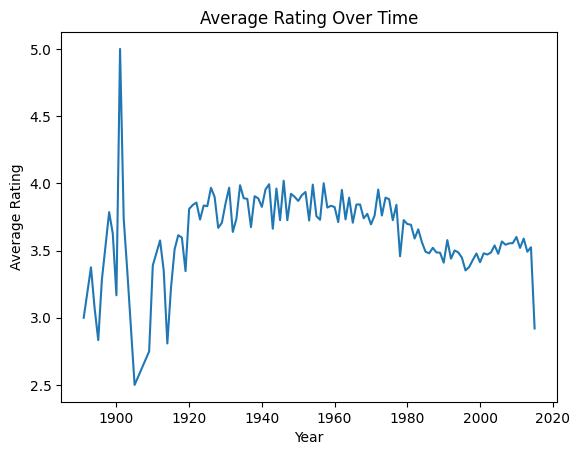

In [ ]:
# 7. Year-Rating Relationship
year_rating = movies.merge(ratings, on='movieId').groupby('year')['rating'].mean()
plt.plot(year_rating.index, year_rating.values)
plt.title('Average Rating Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

## 1.2 Minhash Signatures

Using the **userId** and **movieId** columns, implement your own MinHash function. This function will hash each user's watched movie list, creating a representation that allows for quick comparisons of user similarities.

* **Important**: Implement your MinHash function from scratch — **do not use any pre-built hash functions**
* Use your MinHash function to generate signature vectors for each user based on their rated movies.
* Experiment with different hash functions and threshold values to find the most effective configurations. Report these results.
* Read the class materials and, if necessary, conduct an internet search. The description of hash functions in the [book](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf) may be helpful as a reference.

We create a data structure that maps each user to the unique set of movies they've rated

In [ ]:
userID_movie_map = ratings.groupby('userId')['movieId'].apply(set)
print(userID_movie_map)

userId
1         {2, 3081, 4105, 1036, 5146, 541, 29, 32, 4128,...
2         {3, 260, 2948, 2951, 1544, 1673, 266, 908, 245...
3         {512, 1, 3072, 2053, 2054, 2567, 1544, 2571, 1...
4         {6, 519, 520, 10, 19, 531, 32, 420, 165, 548, ...
5         {2, 515, 260, 1028, 648, 11, 140, 141, 780, 10...
                                ...                        
138489    {2571, 2959, 912, 2324, 2455, 1562, 29, 1061, ...
138490    {1543, 3079, 2573, 2575, 17, 529, 531, 1041, 2...
138491    {1, 8961, 33794, 3608, 4128, 2722, 2085, 2857,...
138492    {2054, 2571, 21, 2599, 5673, 1073, 6711, 58, 2...
138493    {1, 2, 2050, 2051, 69644, 2065, 18, 19, 2078, ...
Name: movieId, Length: 138493, dtype: object


We implement the MinHash algorithm to efficiently estimate the similarity between users based on their movie preferences

In [53]:
import random
import numpy as np

# takes the number of hash functions (num_functions) as input
def generate_hash_functions(num_functions):
  """Generates a list of prime numbers as hash functions."""

  # List of prime numbers to be used as hash functions
  primes = [2, 3, 5, 7, 11, 13]
  # ensures that the number of hash functions requested does not exceed the number of primes available in the list
  num_functions = min(num_functions, len(primes))

  # randomly selects num_functions prime numbers from the list of primes and returns them as a list.
  # This list will be used as the hash functions in the MinHash algorithm
  return random.sample(primes, num_functions)

# takes the number of items (num_items) as input
def create_permutation(num_items):
  """Creates a random permutation of indices."""

  # uses the np.random.permutation() function from NumPy to create...
  # ... a random permutation of the integers from 0 to num_items - 1.
  # This permutation will be used to shuffle the order of the items when calculating the hash values.
  return np.random.permutation(num_items)

# takes the set of movie IDs, a list of hash functions, and a list of permutations as input
def minhash(movie_ids, hash_functions, permutations):
  """Calculates the MinHash signature for a set of movie IDs."""

  # Initialize an empty list to store the MinHash signature
  signature = []

  # Iterate over each hash function
  for h in range(len(hash_functions)):
    # Initialize min_hash with infinity
    # This is because we are looking for the minimum hash value for each hash function
    min_hash = float('inf')

    # Iterate over each movie ID in the user's movie set
    for movie_id in movie_ids:
      # Apply the h-th permutation to the movie ID
      # The permutations[h] gives the permutation array for the h-th hash function
      index = permutations[h][movie_id]
      # Update min_hash if the current index is smaller
      min_hash = min(min_hash, index)
    # Append the minimum hash value to the signature
    signature.append(min_hash)

  return signature

# sets the number of hash functions to use to 100
num_hash_functions = 100
max_movie_id = 0
for movie_ids in userID_movie_map.values:
  for movie_id in movie_ids:
      max_movie_id = max(max_movie_id, movie_id)
# calculates the total number of items (movies) to be considered for the permutations
num_items = max_movie_id + 1

# calls the generate_hash_functions function to create a list of hash functions
hash_functions = generate_hash_functions(num_hash_functions)
# creates a list of permutation matrices, one for each hash function
permutations = [create_permutation(num_items) for _ in range(num_hash_functions)]

# empty dictionary to store the MinHash signatures for each user
user_signatures = {}
# iterates over the user IDs and their corresponding sets of movie IDs
for user_id, movie_ids in userID_movie_map.items():
  # calculates the MinHash signature for the current user using the minhash function...
  # ... and stores it in the user_signatures dictionary
  user_signatures[user_id] = minhash(movie_ids, hash_functions, permutations)

In [54]:
# Print the first 10 user signatures
print("\nFirst 10 User MinHash signatures:")
for i, (user_id, signature) in enumerate(user_signatures.items()):
    if i >= 10:
        break
    print(f"User {user_id}: {signature}")


First 10 User MinHash signatures:
User 1: [1140, 185, 259, 762, 377, 653]
User 2: [1280, 654, 235, 1126, 2839, 1170]
User 3: [1201, 291, 159, 1126, 38, 906]
User 4: [3821, 583, 4930, 214, 1079, 4088]
User 5: [277, 654, 259, 1126, 1079, 1116]
User 6: [277, 654, 307, 1921, 1291, 44]
User 7: [277, 291, 307, 780, 850, 176]
User 8: [586, 583, 1185, 1126, 5743, 3222]
User 9: [2423, 2448, 1592, 745, 377, 5270]
User 10: [5077, 654, 1920, 2453, 1444, 906]


# Algorithmic Question (AQ)

Two brilliant strategists, Arya and Mario, are about to play a game with a sequence of numbers. Arya, as player 1, begins the game, while Mario, player 2, plays 2nd. Their goal is clear: to collect the highest possible score by taking numbers from either end of the sequence, one at a time. They will play in perfect synchronicity, each seeking the advantage.

The sequence represented as an array of *nums*, is laid out in front of them. Arya will start by selecting either the number at the beginning (*nums[0]*) or the end (*nums[nums.length - 1]*) of the array, adding that value to her score. This value is then removed from the beginning or the end of $nums$. Then, it’s Mario’s turn to do the same with the remaining sequence. The game proceeds this way, with each player taking numbers from either end until no numbers are left to claim. The player with the highest score wins.

However, if they end in a tie, Arya, as the first to act, will claim victory by default.

Arya is now before you, asking for help to predict her chances. She wants to know, with her best possible choices, whether she can guarantee a win, assuming both players play with perfect skill.

---
**a)** Help Arya by providing a pseudocode for finding an optimal playing strategy, that is, a strategy that maximizes her value. (Hint: Use recursion, assuming that both players play optimally)

---

We'll employ an adversarial algorithm where two players compete against each other in a zero-sum game (one player's gain is the other player's loss). The winner is determined by the difference between their scores, and Arya's aim is to maximize this difference, while Mario's goal is to minimize it.

To simulate this competitive behavior, we'll utilize the *minimax* algorithm. This algorithm recursively explores all possible moves for both players, assuming they both play optimally. In each turn, Arya will select the move that maximizes the score difference in her favor, while Mario will choose the move that minimizes this difference.

```
FUNCTION calculate_score_difference(nums, is_arya_turn):

    IF nums is empty:
        RETURN 0

    IF is_arya_turn:
          RETURN max(nums[0] + calculate_score_difference(nums[1:], False),
                     nums[-1] + calculate_score_difference(nums[:-1], False))
    ELSE:
          RETURN min(-nums[0] + calculate_score_difference(nums[1:], True),
                     -nums[-1] + calculate_score_difference(nums[:-1], True))

FUNCTION can_arya_win(nums):
    RETURN calculate_score_difference(nums, True) >= 0

For each array nums:
    can_ayra_wins(nums)
```







---
**b)** Write a Python program implementing her game strategy. Try different array lengths to test the algorithm

---

In [ ]:
def calculate_score_difference(nums, is_arya_turn):
  """
  Calculates the optimal score difference that Arya can achieve,
  assuming both players play optimally.

  Args:
    nums: The sequence of numbers.
    is_arya_turn: True if it's Arya's turn, False if it's Mario's turn.

  Returns:
    The optimal score difference that Arya can achieve.
  """

  # Last case: no numbers left; score difference is zero
  if not nums:
    return 0

  if is_arya_turn:
    # Arya's turn: maximize score difference by taking the number...
    # ... that yields the highest score difference after Mario's optimal move
    return max(nums[0] + calculate_score_difference(nums[1:], False),
               nums[-1] + calculate_score_difference(nums[:-1], False))
  else:
    # Mario's turn: minimize Arya's score difference by taking the number...
    # ... that yields the lowest score difference after Arya's optimal move
    return min(-nums[0] + calculate_score_difference(nums[1:], True),
               -nums[-1] + calculate_score_difference(nums[:-1], True))

def can_arya_win(nums):

  # Arya wins if the optimal score difference is non-negative
  # True if Arya can win, False otherwise
  return calculate_score_difference(nums, True) >= 0


# Test cases
test_cases = [
  [1, 5, 2],
  [1, 5, 233, 7],
  [1, 5, 233, 7, 34, 5, 320, 6],
  [1, 5, 233, 7, 2, 3, 120, 320, 9],
  [1, 5, 233, 7, 2, 3, 120, 320, 9, 18, 45, 98, 45, 333, 42, 99, 1000, 23, 4503, 999, 856, 10]
]

# Print the results
for nums in test_cases:
  result = can_arya_win(nums)
  print(f'Array: {nums} --> Can Arya win? {result}')

Array: [1, 5, 2] --> Can Arya win? False
Array: [1, 5, 233, 7] --> Can Arya win? True
Array: [1, 5, 233, 7, 34, 5, 320, 6] --> Can Arya win? True
Array: [1, 5, 233, 7, 2, 3, 120, 320, 9] --> Can Arya win? False
Array: [1, 5, 233, 7, 2, 3, 120, 320, 9, 18, 45, 98, 45, 333, 42, 99, 1000, 23, 4503, 999, 856, 10] --> Can Arya win? True


---
**c)** Is the algorithm efficient? Prove that it is polynomial and provide an asymptotic time complexity bound, or show that it requires exponential time

---

The algorithm exhibits exponential time complexity due to its exploration of all possible move combinations for Arya and Mario. Each number in the sequence presents two choices (take the first or last), resulting in a branching factor of 2 at each step. Consequently, the total number of potential game states to explore is approximately $2^n$, where n is the input array's length. This exponential state growth leads to exponential time complexity.

More formally, the asymptotic time complexity bound is $O(2^n)$. This signifies that the algorithm's running time increases exponentially with the input array's size.

---
**d)** If the algorithm is exponential, explain how to make it polynomial and provide a pseudocode for it. Recompute the computational complexity of the updated algorithm

---

The previous algorithm has an exponential time complexity of $O(2^n)$ due to the recursive exploration of all possible game states. To optimize it to polynomial time, we can employ *memoization*. This technique involves storing the results of calculated states, avoiding redundant computations.

Here's the pseudocode for the memoized algorithm:

```
FUNCTION calculate_score_difference_memo(nums, is_arya_turn, memo):

    If the result for the current state is already memoized, return it
    IF (nums, is_arya_turn) in memo:
        RETURN memo[(nums, is_arya_turn)]

    IF nums is empty:
        RETURN 0

    IF is_arya_turn:
        score = max(nums[0] + calculate_score_difference_memo(nums[1:], False, memo),
                    nums[-1] + calculate_score_difference_memo(nums[:-1], False, memo))

    ELSE:
        score = min(-nums[0] + calculate_score_difference_memo(nums[1:], True, memo),
                    -nums[-1] + calculate_score_difference_memo(nums[:-1], True, memo))

    Memoize the result for the current state
    memo[(nums, is_arya_turn)] = score
    RETURN score

FUNCTION can_arya_win(nums):
    Initialize the memoization dictionary
    memo = {}
    RETURN calculate_score_difference_memo(nums, True, memo) >= 0

For each array nums:
    can_ayra_wins(nums)
```

With *memoization*, the time complexity reduces to $O(n^2)$, where $n$ is the number of elements in the input array. This is because each possible game state (defined by the remaining numbers and whose turn it is) is calculated only once and stored in the memo dictionary. Subsequent encounters of the same state result in a direct lookup from the memo, avoiding redundant recursive calls.

---
**e)** Implement the algorithm in Python. Compare your result values with the previous algorithm. Also compare the running times

---

In [ ]:
def calculate_score_difference_with_memoization(nums, is_arya_turn, memo=None):
    """
    Calculates the optimal score difference that Arya can achieve,
    assuming both players play optimally.

    Args:
        nums: The sequence of numbers.
        is_arya_turn: True if it's Arya's turn, False if it's Mario's turn.
        memo: A dictionary to store the results of the subproblems.

    Returns:
        The optimal score difference that Arya can achieve.
    """

    if memo is None:
        memo = {}  # Initialize the memoization dictionary

    # If the result for the current state is already memoized, return it
    if (tuple(nums), is_arya_turn) in memo:
        return memo[(tuple(nums), is_arya_turn)]

    # Base case: no numbers left, score difference is zero
    if not nums:
        return 0

    if is_arya_turn:
        # Arya's turn: maximize score difference by taking the number...
        # ... that yields the highest score difference after Mario's optimal move
        score = max(
            nums[0] + calculate_score_difference_with_memoization(nums[1:], False, memo),
            nums[-1] + calculate_score_difference_with_memoization(nums[:-1], False, memo)
        )
    else:
        # Mario's turn: minimize Arya's score difference by taking the number...
        # ... that yields the lowest score difference after Arya's optimal move
        score = min(
            -nums[0] + calculate_score_difference_with_memoization(nums[1:], True, memo),
            -nums[-1] + calculate_score_difference_with_memoization(nums[:-1], True, memo)
        )

    # Memoize the result for the current state
    memo[(tuple(nums), is_arya_turn)] = score
    return score

def can_arya_win_with_memoization(nums):
    """
    Determines if Arya can win the game.

    Args:
    nums: The sequence of numbers.

    Returns:
    True if Arya can win, False otherwise.
    """

    # Arya wins if the optimal score difference is non-negative
    return calculate_score_difference_with_memoization(nums, True) >= 0

# Test cases
test_cases = [
  [1, 5, 2],
  [1, 5, 233, 7],
  [1, 5, 233, 7, 34, 5, 320, 6],
  [1, 5, 233, 7, 2, 3, 120, 320, 9]
]

# Print the results
for nums in test_cases:
  result = can_arya_win_with_memoization(nums)
  print(f'Array: {nums} --> Can Arya win? {result}')

Array: [1, 5, 2] --> Can Arya win? False
Array: [1, 5, 233, 7] --> Can Arya win? True
Array: [1, 5, 233, 7, 34, 5, 320, 6] --> Can Arya win? True
Array: [1, 5, 233, 7, 2, 3, 120, 320, 9] --> Can Arya win? False


Below we compare the execution times of the two versions of code (without and with memoization) on two arrays, one short (4 elements) and the other long (22 elements).

We can note that:
* on short arrays, with memoization the management of the *memo dictionary* negates the benefit of avoiding redundant calculations;
* on long arrays, memoization significantly reduces execution times.


In [ ]:
import time

# Test cases
test_cases = [
    [1, 5, 233, 7],
    [1, 5, 233, 7, 2, 3, 120, 320, 9, 18, 45, 98, 45, 333, 42, 99, 1000, 23, 4503, 999, 856, 10]
]

for nums in test_cases:
    # Time the execution without memoization
    start_time = time.time()
    result_no_memo = can_arya_win(nums)
    end_time = time.time()
    time_no_memo = end_time - start_time

    # Time the execution with memoization
    start_time = time.time()
    result_memo = can_arya_win_with_memoization(nums)
    end_time = time.time()
    time_memo = end_time - start_time

    print(f'Array: {nums}')
    print(f'  Can Arya win? {result_no_memo} (without memoization)')
    print(f'  Execution time (no memo): {time_no_memo:.6f} seconds')
    print(f'  Can Arya win? {result_memo} (with memoization)')
    print(f'  Execution time (memo): {time_memo:.6f} seconds')

Array: [1, 5, 233, 7]
  Can Arya win? True (without memoization)
  Execution time (no memo): 0.000029 seconds
  Can Arya win? True (with memoization)
  Execution time (memo): 0.000032 seconds
Array: [1, 5, 233, 7, 2, 3, 120, 320, 9, 18, 45, 98, 45, 333, 42, 99, 1000, 23, 4503, 999, 856, 10]
  Can Arya win? True (without memoization)
  Execution time (no memo): 3.670313 seconds
  Can Arya win? True (with memoization)
  Execution time (memo): 0.000525 seconds


---
**f)** Finally, consult LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to craft a third, optimized implementation and analyze its time complexity. Also, explain if the LLM is doing a good job and how you can evaluate whether the suggested solution works properly

---

We asked *Claude AI* to write an optimized program implementing Ayra's game strategy.

**Key Strategy Components**
1. **Dynamic Programming Approach**: 2D table $dp$ where $dp[i][j]$ represents the maximum score difference between Arya and Mario for the subarray $nums[i:j+1]$. The score difference is calculated as (Arya's score - Mario's score)
2. **Winning Condition**: If $dp[0][n-1]$ is non-negative (>= 0), Arya guarantees at least a tie, which means a win for her.
3. **Recursive Strategy**: At each step, a player chooses either the left or right end of the remaining sequence. The choice maximizes the score difference in their favor.

**Evaluation**:

1. **Correctness**: The algorithm correctly implements the dynamic programming approach to solve this problem. It considers all possible choices for Arya and Mario and optimizes for the maximum score difference.
2. **Efficiency**: The time complexity is $O(n^2)$ due to the nested loops to fill the $dp$ array. The space complexity is also $O(n^2)$ to store the $dp$ array.
3. **Clarity**: The code is well-structured and includes comments explaining the logic. The variable names are meaningful, and the use of dynamic programming is clear.



In [ ]:
class PredictWinner:
    def predict_the_winner(self, nums):
        """
        Determine if Arya can guarantee a win with optimal play.

        Args:
            nums (List[int]): The sequence of numbers to play with

        Returns:
            bool: True if Arya can guarantee a win, False otherwise
        """
        n = len(nums)
        # Create a 2D DP table to store maximum score differences
        # dp[i][j] represents the maximum score difference
        # (Arya's score - Mario's score) for the subarray nums[i:j+1]
        dp = [[0] * n for _ in range(n)]

        # Initialize base case: single number subarrays
        for i in range(n):
            dp[i][i] = nums[i]

        # Build the DP table diagonally
        # Increasing subarray length from 2 to n
        for length in range(2, n + 1):
            for i in range(n - length + 1):
                j = i + length - 1

                # Score difference when choosing left end
                left_choice = nums[i] - dp[i+1][j]

                # Score difference when choosing right end
                right_choice = nums[j] - dp[i][j-1]

                # Take the maximum possible score difference
                dp[i][j] = max(left_choice, right_choice)

        # If the final score difference is >= 0, Arya wins (or ties)
        return dp[0][n-1] >= 0

def test_prediction_strategy():
    """
    Test cases to validate the prediction strategy
    """
    solution = PredictWinner()

    # Test case 1: Arya can guarantee a win
    print("Test Case 1:", solution.predict_the_winner([1, 5, 2]) == True)

    # Test case 2: Balanced case where Arya wins
    print("Test Case 2:", solution.predict_the_winner([1, 5, 233, 7]) == True)

# Run the test cases
test_prediction_strategy()

Test Case 1: False
Test Case 2: True
